#### **Установка всех необходимых библиотек**

In [1]:
from google.colab import files
from IPython.display import clear_output

files.upload()
clear_output()

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle/

In [4]:
!pip install -U torchmetrics
clear_output()

#### **Скачивание данных**

In [5]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 73% 30.0M/41.0M [00:00<00:00, 114MB/s] 
100% 41.0M/41.0M [00:00<00:00, 113MB/s]


In [6]:
!unzip fake-and-real-news-dataset.zip
!rm -rf fake-and-real-news-dataset.zip True.csv

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [7]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2022-03-18 20:28:42--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.179.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.179.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  46.2MB/s    in 34s     

2022-03-18 20:29:17 (46.2 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



#### **Импорт библиотек**

In [8]:
import random
import re
from collections import Counter
from itertools import chain
from string import punctuation

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gensim.models import KeyedVectors
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid
from torch.utils.data import (
    DataLoader,
    Dataset,
    RandomSampler,
    SequentialSampler,
)
from torchmetrics.functional.classification.f_beta import f1_score
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 6)

In [9]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [10]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stop = set(stopwords.words("english"))

In [12]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#### **Препроцессинг**

In [13]:
df = pd.read_csv("Fake.csv").drop_duplicates().reset_index(drop=True)

In [14]:
df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Посмотрим на распределение категорий.

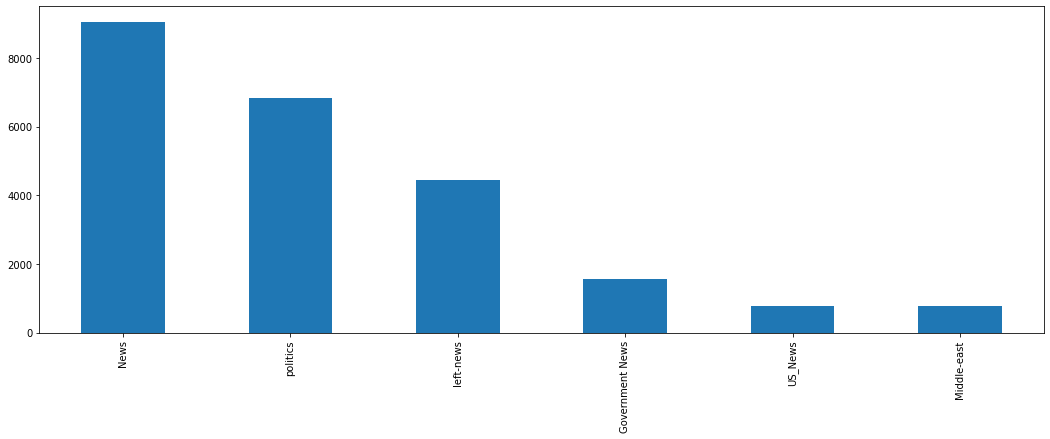

In [15]:
df["subject"].value_counts().plot.bar()

Несбалансированно, следовательно, когда будем делить датасет на обучающую и тестовую выборку, нужно использовать аргумент stratify.

In [16]:
def clean_text(text: str) -> str:
    """
    Функция для препроцессинга текстов.
    Приводит текст к нижнему регистру,
    удаляет пунктуацию и стоп-слова,
    проводит токенизацию.

    Parameters:
        text: str

    Returns:
        str
    """
    text = text.lower()
    text = text.translate(str.maketrans("", "", punctuation))
    return [word for word in word_tokenize(text) if word not in stop]

In [17]:
df["text"] = df["text"].apply(clean_text)

In [18]:
categories = df["subject"].astype("category")
df["category"] = categories.cat.codes

In [19]:
target_names = categories.cat.categories
print(dict(enumerate(target_names)))

{0: 'Government News', 1: 'Middle-east', 2: 'News', 3: 'US_News', 4: 'left-news', 5: 'politics'}


In [20]:
df = df[["text", "category"]]

In [21]:
df.head()

,text,category
0,"[donald, trump, wish, americans, happy, new, y...",2
1,"[house, intelligence, committee, chairman, dev...",2
2,"[friday, revealed, former, milwaukee, sheriff,...",2
3,"[christmas, day, donald, trump, announced, wou...",2
4,"[pope, francis, used, annual, christmas, day, ...",2


In [22]:
vocab = Counter(chain(*df["text"]))
print(f"Всего уникальных токенов: {len(vocab)}")

Всего уникальных токенов: 186722


In [23]:
filtered_vocab = {word for word in vocab if vocab[word] > 2}
print(f"Токенов, встретившихся больше 2 раз: {len(filtered_vocab)}")

Токенов, встретившихся больше 2 раз: 59948


In [24]:
word2id = {"UNK": 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [25]:
print(f"Самое длинное предложение: {max([len(text) for text in df['text']])}")
print(
    f"Средняя длина предложения: {np.mean([len(text) for text in df['text']])}"
    )

Самое длинное предложение: 4920
Средняя длина предложения: 235.27089189879888


Ограничим длину предложения — до чуть больше средней.

In [26]:
MAX_LEN = 256

In [27]:
word2vec = KeyedVectors.load_word2vec_format(
    "GoogleNews-vectors-negative300.bin.gz", binary=True
    )

In [28]:
weights = np.zeros((len(word2id), 300))

unknown_word = 0
for word, i in word2id.items():
    try:
        weights[i] = word2vec[word]
    except KeyError:
        unknown_word += 1
        weights[i] = np.random.uniform(-0.25, 0.25, 300)

weights = torch.FloatTensor(weights)

In [29]:
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["category"]
    )

In [30]:
!rm Fake.csv GoogleNews-vectors-negative300.bin.gz

In [31]:
del word2vec

#### **Dataset & DataLoader**

In [32]:
class NewsDataset(Dataset):
    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset["text"].values
        self.target = dataset["category"].values
        self.length = dataset.shape[0]
        self.word2id = word2id
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index]
        token_ids = []
        ids = torch.LongTensor(
            [self.word2id[token]
             if token in self.word2id else self.word2id["UNK"]
             for token in tokens][:MAX_LEN]
             )
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): 
        ids, y = list(zip(*batch))
        padded_ids = torch.LongTensor(
            torch.stack(
                [F.pad(idx, (1, MAX_LEN - len(idx))) for idx in ids], dim=0
                )
            ).to(self.device)
        y = torch.LongTensor(y).view(len(y)).to(self.device)
        return padded_ids, y

In [33]:
train_dataset = NewsDataset(train_df, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(
    train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler,
    batch_size=128
    )

val_dataset = NewsDataset(val_df, word2id, DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(
    val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler,
    batch_size=128
    )

#### **Архитектура модели**

In [34]:
class RNNCell(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.W_i = torch.randn(self.embedding_size, self.hidden_size)
        self.W_h = torch.randn(self.hidden_size, self.hidden_size)
        self.b = torch.randn(1, self.hidden_size)
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        cell_output = self.tanh(x @ self.W_i + self.b + h @ self.W_h + self.b)
        return cell_output

In [35]:
class LSTMCell(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.W_i = torch.randn(self.embedding_size, self.hidden_size)
        self.W_h = torch.randn(self.hidden_size, self.hidden_size)
        self.b = torch.randn(1, self.hidden_size)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, h, cell_state):
        i = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        f = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        g = self.tanh(x @ self.W_i + self.b + h @ self.W_h + self.b)
        o = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        cell_state = cell_state * f + i * g
        cell_output = self.tanh(cell_state) * o
        return cell_output, cell_state

In [36]:
class GRUCell(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super().__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.W_i = torch.randn(self.embedding_size, self.hidden_size)
        self.W_h = torch.randn(self.hidden_size, self.hidden_size)
        self.b = torch.randn(1, self.hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        r = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b)
        z = self.sigmoid(x @ self.W_i + self.b + h @ self.W_h + self.b) 
        n = self.tanh(x @ self.W_i + self.b + r * (h @ self.W_h + self.b))
        cell_output = (1 - z) * n + z * h
        return cell_output

In [37]:
class RNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, cell_type="lstm"):
        super().__init__()
        self.hidden_size = out_channels
        self.cell_type = cell_type
        if self.cell_type == "rnn":
            self.rnn_cell = RNNCell(in_channels, out_channels)
        elif cell_type == "lstm":
            self.rnn_cell = LSTMCell(in_channels, out_channels)
        elif self.cell_type == "gru":
            self.rnn_cell = GRUCell(in_channels, out_channels)
        else:
            raise ValueError("cell_type must be one of ['rnn', 'lstm', 'gru']")

    def forward(self, x):
        hidden_state = torch.zeros(
            (self.hidden_size), dtype=torch.float32
            ).to(DEVICE)
        cell_state = torch.zeros(
            (self.hidden_size), dtype=torch.float32
            ).to(DEVICE)
        seq_length = x.size()[1]
        for i in range(seq_length):
            input_token = x[:, i, :]
            if self.cell_type == "lstm":
                hidden_state, _ = self.rnn_cell(
                    input_token, hidden_state, cell_state
                    )
            else:
                hidden_state = self.rnn_cell(input_token, hidden_state)
        return hidden_state

In [38]:
class CLSTM(nn.Module):
    def __init__(
        self, weights, vocab_size, max_len, cell_type="lstm", filter_size=2
        ):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.max_len = max_len
        self.cell_type = cell_type
        self.max_filter = self.max_len - filter_size + 1
        self.vocab_size = vocab_size      
        self.conv = nn.Conv1d(
            in_channels=300, out_channels=150, kernel_size=filter_size
            )
        self.rnn = RNNLayer(
            in_channels=150, out_channels=150, cell_type=self.cell_type
            )
        self.relu = nn.ReLU()
        self.out = nn.Softmax(dim=1)
        self.linear = nn.Linear(150, 6)

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1, 2)
        hidden = self.relu(self.conv(embedded))
        hidden = hidden[:, :, :self.max_filter]
        hidden_state = self.rnn(hidden.transpose(1, 2))
        logits = self.out(self.linear(torch.squeeze(hidden_state, 0)))
        return logits

#### **Функции для обучения и валидации**

In [46]:
def train_epoch(model, iterator, optimizer, criterion, metric, n_epoch):
    progress_bar = tqdm(
        total=len(iterator.dataset), desc=f"Epoch {n_epoch + 1}"
        )
    epoch_loss = 0.0
    epoch_metric = 0.0
    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        # нормализуем веса, чтобы лосс не был NaN
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        epoch_loss += loss.item()
        batch_metric = metric(
            preds.argmax(1).long(), ys.long(), average="weighted",
            num_classes=6, ignore_index=False
            )
        epoch_metric += batch_metric.cpu().numpy()
        progress_bar.update(texts.shape[0])

    progress_bar.close()
    return epoch_loss / len(iterator), epoch_metric / len(iterator)

In [47]:
def evaluate(model, iterator, criterion, metric):
    epoch_loss = 0.0
    epoch_metric = 0.0
    model.eval()

    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = metric(
                preds.argmax(1).long(), ys.long(), average="weighted",
                num_classes=6, ignore_index=False
                )
            epoch_metric += batch_metric.cpu().numpy()

    return epoch_loss / len(iterator), epoch_metric / len(iterator)

In [48]:
def train(
    model, train_iterator, val_iterator, optimizer, criterion, metric, epochs
    ):
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []

    for n in range(epochs):
        print("Training")
        train_loss, train_score = train_epoch(
            model, train_iterator, optimizer, criterion, metric, n
            )
        train_losses.append(train_loss)
        train_scores.append(train_score)
        print(f"train loss: {train_loss} train score: {train_score}")
        print("Validation")
        val_loss, val_score = evaluate(model, val_iterator, criterion, metric)
        val_losses.append(val_loss)
        val_scores.append(val_score)
        print(f"val loss: {val_loss} val score: {val_score}")

    return train_losses, train_scores, val_losses, val_scores

In [49]:
def predict(model, iterator):
    true = []
    preds = []
    model.eval()

    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds.extend(
                torch.argmax(model(texts), dim=1).cpu().detach().numpy()
                )
            true.extend(ys.cpu().detach().numpy())
    return true, preds

In [52]:
def grid_search(
    train_iterator, val_iterator, param_grid, weights, vocab_size, max_len,
    metric=f1_score, epochs=5
    ):
    results = []
    best_metric = 0.0
    best_model = None
    best_params = None

    for params in tqdm(ParameterGrid(param_grid)):
        print(f"Params: {params}")
        curr_params = {
            "weights": weights,
            "vocab_size": vocab_size,
            "max_len": max_len
        }
        curr_params.update(params)
        model = CLSTM(**curr_params)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        for param in model.parameters():
            param.requires_grad=True
        model = model.to(DEVICE)
        criterion = criterion.to(DEVICE)
        train_losses, train_scores, val_losses, val_scores = train(
            model, train_iterator, val_iterator, optimizer, criterion, metric,
            epochs
            )

        if val_scores[-1] > best_metric:
            best_metric = val_scores[-1]
            best_model = model
            best_params = params

        results.append({
            "params": params,
            "train losses": train_losses,
            "train scores": train_scores,
            "val losses": val_losses,
            "val scores": val_scores,
        })
    print("\n")

    return results, best_metric, best_model, best_params

#### **Эксперименты**

In [44]:
param_grid = {
    "cell_type": ["rnn", "lstm", "gru"],
    "filter_size": [2, 3],
}

In [ ]:
results, best_f1, best_model, best_params = grid_search(
    train_iterator, val_iterator, param_grid, weights, len(word2id), MAX_LEN
    )

  0%|          | 0/6 [00:00<?, ?it/s]

Params: {'cell_type': 'rnn', 'filter_size': 2}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.010332195068864772
Validation
val loss: nan val score: 0.009015898585218835
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009121771263541514
Validation
val loss: nan val score: 0.008974614729349678
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.00923568426415983
Validation
val loss: nan val score: 0.008944693638162839
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.00919967915603042
Validation
val loss: nan val score: 0.009148080808085364
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009199170120334456
Validation
val loss: nan val score: 0.00932268171596366
Params: {'cell_type': 'rnn', 'filter_size': 3}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009230085378148447
Validation
val loss: nan val score: 0.009056110834904216
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009219879667800503
Validation
val loss: nan val score: 0.009240002673421358
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009251587939263341
Validation
val loss: nan val score: 0.009108096726138043
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009311370943200958
Validation
val loss: nan val score: 0.009022249512978503
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009145235991244819
Validation
val loss: nan val score: 0.009115220204851514
Params: {'cell_type': 'lstm', 'filter_size': 2}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009079779054792155
Validation
val loss: nan val score: 0.009340147876394662
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009269429637051067
Validation
val loss: nan val score: 0.009292390826787497
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009252207787694778
Validation
val loss: nan val score: 0.009182624462236827
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009171752718461006
Validation
val loss: nan val score: 0.009020986482249322
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009264405734431581
Validation
val loss: nan val score: 0.009171305343861113
Params: {'cell_type': 'lstm', 'filter_size': 3}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009247540948092051
Validation
val loss: nan val score: 0.008969025371747243
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009361051759511536
Validation
val loss: nan val score: 0.00922144836953816
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009158549124698098
Validation
val loss: nan val score: 0.008866939643347586
Training


Epoch 4:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009315716402864932
Validation
val loss: nan val score: 0.008969898360806543
Training


Epoch 5:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009151637714140777
Validation
val loss: nan val score: 0.009130845525195016
Params: {'cell_type': 'gru', 'filter_size': 2}
Training


Epoch 1:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009145789208337285
Validation
val loss: nan val score: 0.009538738492788194
Training


Epoch 2:   0%|          | 0/18782 [00:00<?, ?it/s]

train loss: nan train score: 0.009217221888778477
Validation
val loss: nan val score: 0.009335190108096277
Training


Epoch 3:   0%|          | 0/18782 [00:00<?, ?it/s]

#### **Оценка результатов**
Выведем наилучшие параметры модели.

In [ ]:
print(best_params)

In [47]:
print(best_f1)

0.38423080540992116


In [50]:
results_df = pd.DataFrame(results)

In [55]:
len(results)

6

In [51]:
results_df.insert(
    0, "cell_type", results_df["params"].apply(lambda x: x["cell_type"])
    )
results_df.insert(
    1, "filter_size", results_df["params"].apply(lambda x: x["filter_size"])
    )
results_df.insert(
    2, "loss", results_df["val losses"].apply(lambda x: x[-1])
    )
results_df.insert(
    3, "f1-score", results_df["val scores"].apply(lambda x: x[-1])
    )
results_df = results_df.drop("params", axis=1)

Посмотрим на loss и f1-score при разных параметрах (отсортируем параметры от самых лучших к самым худшим):

In [53]:
results_df = results_df.sort_values(
    ["f1-score", "loss"], ascending=[False, True]
    ).reset_index(drop=True)

In [56]:
results_df.head(6)

,cell_type,filter_size,loss,f1-score,train losses,train scores,val losses,val scores
5,gru,3,1.562707,0.384231,"[1.5980120735103582, 1.5740567745805598, 1.568...","[0.36597332500276114, 0.37446298972279035, 0.3...","[1.5770378112792969, 1.569912823470863, 1.5664...","[0.3772152807261493, 0.38049259137462926, 0.38..."
4,gru,2,1.565444,0.376790,"[1.6045713603091079, 1.5802325204927095, 1.574...","[0.3573508305209024, 0.37039663738944906, 0.37...","[1.5815606922716707, 1.5736654642465953, 1.569...","[0.3673053367717846, 0.37411182716086105, 0.37..."
2,lstm,2,NaN,0.009377,"[nan, nan, nan, nan, nan]","[0.02460334633142833, 0.009164733540181222, 0....","[nan, nan, nan, nan, nan]","[0.009143825639290986, 0.008875854075036792, 0..."
1,rnn,3,NaN,0.009370,"[nan, nan, nan, nan, nan]","[0.010392803006621749, 0.009070763171398632, 0...","[nan, nan, nan, nan, nan]","[0.009109636730942372, 0.00920230508986483, 0...."
0,rnn,2,NaN,0.009357,"[nan, nan, nan, nan, nan]","[0.009765938973112894, 0.009120718419209731, 0...","[nan, nan, nan, nan, nan]","[0.009109754813835025, 0.00904781066787404, 0...."
3,lstm,3,NaN,0.008872,"[nan, nan, nan, nan, nan]","[0.01037230858338528, 0.009046942033831879, 0....","[nan, nan, nan, nan, nan]","[0.009215429727290128, 0.008992557508266857, 0..."


Посмотрим на то, как менялись loss и f1-score в процессе обучения модели с наилучшими параметрами.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(results_df["train losses"][0], label="train")
ax1.plot(results_df["val losses"][0], label="val")
ax1.set_title("BCE loss value")
ax1.set(xlabel="epoch", ylabel="BCE loss")
ax1.legend(loc="upper right")

ax2.plot(results_df["train scores"][0], label="train")
ax2.plot(results_df["val scores"][0], label="val")
ax2.set_title("F1 score")
ax2.set(xlabel="epoch", ylabel="F1 score")
ax2.legend(loc="upper right")

fig.suptitle("Training (filter_sizes=, drop_start=)")

Посмотрим на предсказания наилучшей модели.

In [ ]:
y_true, y_pred = predict(best_model, val_iterator)

Построим матрицу ошибок.

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=target_names)
plt.xlabel("y_pred")
plt.ylabel("y_true")

Посмотрим на метрики оценки качества классификации для разных классов.

In [ ]:
print(classification_report(y_true, y_pred, target_names=target_names))

#### **Выводы**